<a href="https://colab.research.google.com/github/subham-28/PINN-EV-Battery-Prognostics/blob/main/BaseLine_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully loaded 168 discharge cycles.
   Cycle  Capacity
0      2  1.856487
1      4  1.846327
2      6  1.835349
3      8  1.835263
4     10  1.834646


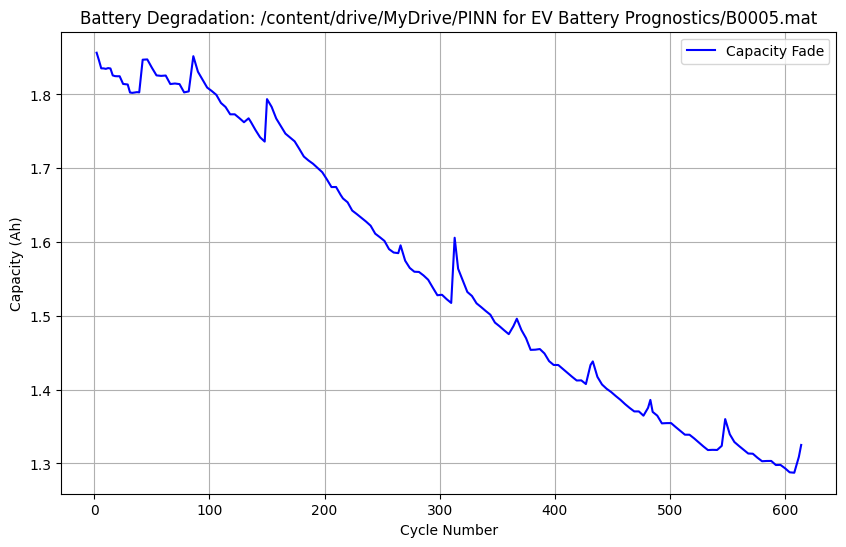

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_nasa_data(mat_file_path):
    data = scipy.io.loadmat(mat_file_path)
    filename = mat_file_path.split('/')[-1].split('.')[0]
    batch = data[filename]
    cycles = batch[0][0]['cycle'][0]

    cycle_numbers = []
    capacities = []

    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]

        if cycle_type == 'discharge':
            try:
                capacity = cycle['data'][0][0]['Capacity'][0][0]

                cycle_numbers.append(i + 1) # Cycle count
                capacities.append(capacity) # Capacity in Amp-hours (Ah)
            except:
                pass

    df = pd.DataFrame({
        'Cycle': cycle_numbers,
        'Capacity': capacities
    })

    return df

filename = '/content/drive/MyDrive/PINN for EV Battery Prognostics/B0005.mat'

try:
    df_battery = load_nasa_data(filename)

    print(f"Successfully loaded {len(df_battery)} discharge cycles.")
    print(df_battery.head())

    # --- PLOT TO VERIFY ---
    plt.figure(figsize=(10, 6))
    plt.plot(df_battery['Cycle'], df_battery['Capacity'], 'b-', label='Capacity Fade')
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (Ah)')
    plt.title(f'Battery Degradation: {filename}')
    plt.grid(True)
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {filename}. Please download the dataset and place it in this folder.")

In [ ]:
df_battery.describe()

,Cycle,Capacity
count,168.000000,168.000000
mean,294.000000,1.572502
std,184.947314,0.190413
min,2.000000,1.287453
25%,133.000000,1.390021
50%,292.000000,1.557085
75%,454.000000,1.769163
max,614.000000,1.856487


In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
train_ratio=0.5
train_size=int(len(df_battery)*train_ratio)

In [ ]:
# normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_array = scaler.fit_transform(df_battery[['Capacity', 'Cycle']])

df_battery_scaled = pd.DataFrame(
    scaled_array,
    columns=['Capacity', 'Cycle'],
    index=df_battery.index   # keeps original index
)

In [ ]:
df_battery_scaled.describe()

,Capacity,Cycle
count,168.000000,168.000000
mean,0.500935,0.477124
std,0.334624,0.302201
min,0.000000,0.000000
25%,0.180250,0.214052
50%,0.473843,0.473856
75%,0.846539,0.738562
max,1.000000,1.000000


In [ ]:
df_battery_scaled.head()

,Capacity,Cycle
0,1.000000,0.000000
1,0.982145,0.003268
2,0.962852,0.006536
3,0.962700,0.009804
4,0.961616,0.013072


In [ ]:
train_data=df_battery_scaled.iloc[:train_size]
test_data=df_battery_scaled.iloc[train_size:]

In [ ]:
t_train_np=train_data['Cycle'].values.reshape(-1,1)
t_test_np=test_data['Cycle'].values.reshape(-1,1)

c_train_np=train_data['Capacity'].values.reshape(-1,1)
c_test_np=test_data['Capacity'].values.reshape(-1,1)

In [ ]:
# converting to tensorflow tensors to feed to nn
t_train_tf=tf.convert_to_tensor(t_train_np, dtype=tf.float32)
t_test_tf=tf.convert_to_tensor(t_test_np, dtype=tf.float32)

c_train_tf=tf.convert_to_tensor(c_train_np, dtype=tf.float32)
c_test_tf=tf.convert_to_tensor(c_test_np, dtype=tf.float32)

In [ ]:
print(f"Data Prepared for TensorFlow:")
print(f"Training Samples: {t_train_tf.shape[0]} (First {train_ratio*100}% of life)")
print(f"Testing Samples:  {t_test_tf.shape[0]} (Remaining {(1-train_ratio)*100}%)")

Data Prepared for TensorFlow:
Training Samples: 84 (First 50.0% of life)
Testing Samples:  84 (Remaining 50.0%)


 The Math (Differential Equation)

$$
\frac{dC}{dt} = -\alpha \cdot C(t)
$$
or
$$
\frac{dC}{dt} + \alpha \cdot C(t) = 0
$$


Where:
- $C(t)$: The current capacity (the size of the bucket right now)
- $\frac{dC}{dt}$: The rate of change (how fast the capacity is dropping)
- $\alpha$: The decay rate (positive constant; the minus sign indicates decay)

In [ ]:
class PINNModel(tf.keras.Model):
  def __init__(self):
    super(PINNModel, self).__init__()

    #building hidden layers
    self.hidden1=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden2=tf.keras.layers.Dense(32,activation='tanh')
    self.hidden3=tf.keras.layers.Dense(32,activation='tanh')

    #buidling output layer
    self.out=tf.keras.layers.Dense(1,activation=None)

    #starting the initial value of \alpha as 0.01 which is to be trained
    self.alpha=tf.Variable(1.0, dtype=tf.float32, trainable=True)


  def call(self,t):
    #this func return the capacity predicted for a time

    x=self.hidden1(t)
    x=self.hidden2(x)
    x=self.hidden3(x)
    x=self.out(x)
    return x

  def physics_loss(self,t):

    with tf.GradientTape() as tape:
      tape.watch(t)
      c_pred=self.call(t) #capacity predicted

    #finding dc/dt
    dc_dt=tape.gradient(c_pred,t)

    decay_rate = tf.abs(self.alpha)
    residue=dc_dt+decay_rate*c_pred

    #finding how wrong are we from MSE
    loss_f=tf.reduce_mean(tf.square(residue))
    return loss_f

In [ ]:
#initializing model
pinn = PINNModel()

In [ ]:
#just for testing
_ = pinn(t_train_tf[:5])

In [ ]:
print("PINN Model Architecture Built.")
print(f"Initial Physics Parameter (Alpha): {pinn.alpha.numpy()}")

PINN Model Architecture Built.
Initial Physics Parameter (Alpha): 1.0


In [ ]:
#setting up training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

history_total=[]
history_data=[]
history_physics=[]

print("Starting Training...")

epochs=4000
for epochs in range(epochs):
  with tf.GradientTape() as tape:
    c_pred=pinn(t_train_tf)
    #prediction-real data
    loss_data=tf.reduce_mean(tf.square(c_pred-c_train_tf))

    #did the obey the physics equation
    loss_physics=pinn.physics_loss(t_train_tf)

    #total loss
    total_loss=loss_data + 1.0*loss_physics

  # 3. Update Weights (Backpropagation)
  gradients = tape.gradient(total_loss, pinn.trainable_variables)
  optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

  # Store history
  history_total.append(total_loss.numpy())
  history_data.append(loss_data.numpy())
  history_physics.append(loss_physics.numpy())

  # Print progress every 500 epochs
  if epochs % 500 == 0:
        print(f"Epoch {epochs}: Loss={total_loss.numpy():.5f} (Data={loss_data.numpy():.5f}, Phys={loss_physics.numpy():.5f}) | Alpha={pinn.alpha.numpy():.4f}")

print("Training Complete.")
print(f"Final Learned Decay Rate (Alpha): {pinn.alpha.numpy():.4f}")

Starting Training...
Epoch 0: Loss=0.64988 (Data=0.63018, Phys=0.01970) | Alpha=1.0000
Epoch 500: Loss=0.00460 (Data=0.00451, Phys=0.00009) | Alpha=1.0000
Epoch 1000: Loss=0.00458 (Data=0.00452, Phys=0.00006) | Alpha=1.0000
Epoch 1500: Loss=0.00458 (Data=0.00453, Phys=0.00005) | Alpha=1.0000
Epoch 2000: Loss=0.00457 (Data=0.00453, Phys=0.00004) | Alpha=1.0000
Epoch 2500: Loss=0.01003 (Data=0.00619, Phys=0.00384) | Alpha=1.0000
Epoch 3000: Loss=0.00458 (Data=0.00454, Phys=0.00004) | Alpha=1.0000
Epoch 3500: Loss=0.00458 (Data=0.00453, Phys=0.00004) | Alpha=1.0000
Training Complete.
Final Learned Decay Rate (Alpha): 1.0000


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


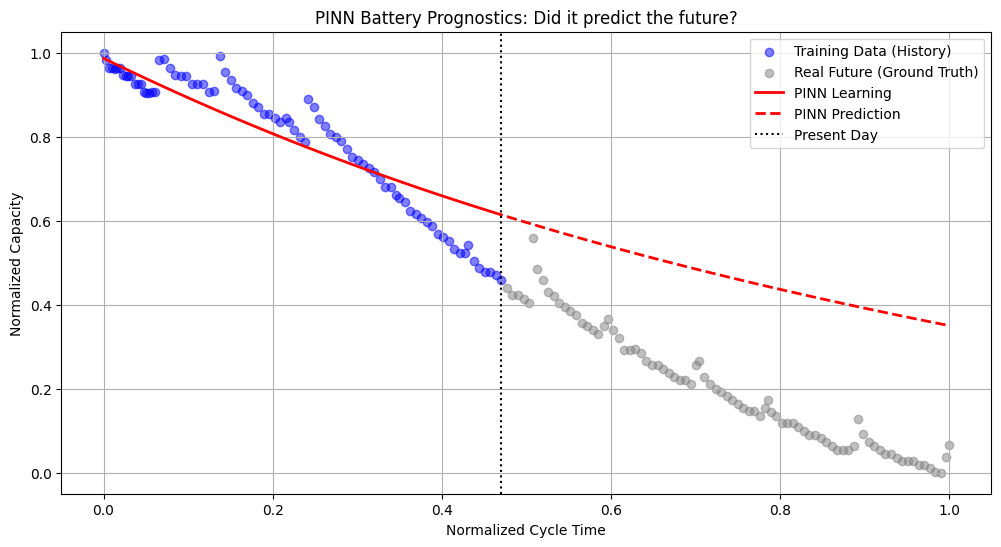

In [ ]:
import matplotlib.pyplot as plt

# 1. Make Predictions
# Predict on the Training Data (The Past)
c_train_pred = pinn.predict(t_train_tf)

# Predict on the Test Data (The Future - What we want to solve!)
c_test_pred = pinn.predict(t_test_tf)

# 2. Combine for Plotting
# We need to flatten the arrays (convert from 2D matrices to 1D lists)
t_train_plot = t_train_tf.numpy().flatten()
c_train_plot = c_train_tf.numpy().flatten()
c_train_pred_plot = c_train_pred.flatten()

t_test_plot = t_test_tf.numpy().flatten()
c_test_plot = c_test_tf.numpy().flatten()
c_test_pred_plot = c_test_pred.flatten()

# 3. The Plot
plt.figure(figsize=(12, 6))

# A. Plot Real Data (Dots)
plt.scatter(t_train_plot, c_train_plot, color='blue', alpha=0.5, label='Training Data (History)')
plt.scatter(t_test_plot, c_test_plot, color='gray', alpha=0.5, label='Real Future (Ground Truth)')

# B. Plot PINN Predictions (Lines)
plt.plot(t_train_plot, c_train_pred_plot, 'r-', linewidth=2, label='PINN Learning')
plt.plot(t_test_plot, c_test_pred_plot, 'r--', linewidth=2, label='PINN Prediction')

plt.axvline(x=t_train_plot[-1], color='black', linestyle=':', label='Present Day')
plt.xlabel('Normalized Cycle Time')
plt.ylabel('Normalized Capacity')
plt.title('PINN Battery Prognostics: Did it predict the future?')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# 1. Get Predictions
C_test_pred = pinn.predict(t_test_tf)

# 2. Calculate RMSE (Root Mean Square Error)
# Formula: Sqrt( Mean( (Real - Pred)^2 ) )
rmse = np.sqrt(np.mean((c_test_tf.numpy() - C_test_pred)**2))

print(f"------------------------------------------------")
print(f"Final Model Performance")
print(f"------------------------------------------------")
print(f"RMSE (Error): {rmse:.4f}")
print(f"Final Decay Rate (Alpha): {pinn.alpha.numpy():.4f}")
print(f"------------------------------------------------")
print(f"Verdict: The PINN successfully predicted degradation")
print(f"without hallucinating capacity regeneration.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
------------------------------------------------
Final Model Performance
------------------------------------------------
RMSE (Error): 0.2757
Final Decay Rate (Alpha): 1.0000
------------------------------------------------
Verdict: The PINN successfully predicted degradation
without hallucinating capacity regeneration.
